In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from time import time
from collections import deque
%matplotlib inline

In [2]:
#Load MNIST
#http://yann.lecun.com/exdb/mnist/
def unpickle_MNIST(image, label):
    #Read Image data
    image_set = open(image, 'rb')
    magic_number = struct.unpack(">i", image_set.read(4))[0]
    number_images = struct.unpack(">i", image_set.read(4))[0]
    rows = struct.unpack(">i", image_set.read(4))[0]
    cols = struct.unpack(">i", image_set.read(4))[0]
    image_set_data = np.reshape(np.fromstring(image_set.read(), dtype = np.uint8), (number_images, rows * cols))
    image_set.close()
    #Read Label data
    label_set = open(label, 'rb')
    magic_number = struct.unpack(">i", label_set.read(4))[0]
    number_of_items = struct.unpack(">i", label_set.read(4))[0]
    label_set_data = np.reshape(np.fromstring(label_set.read(), dtype = np.uint8), (number_of_items))
    label_set.close()    
    return image_set_data.reshape(image_set_data.shape[0], 1, 28, 28), label_set_data

In [3]:
def shuffle(X, y):
    """
    Argument:
    X -- all training_data
    y -- all training_label
    
    Return:
    X_train -- training_dataset
    y_train -- training_labelset
    X_cross -- cross_validation_dataset
    y_cross -- cross_validation_labelset
    """
    data_count = X.shape[0]
    shuffle_order = np.arange(data_count)
    np.random.shuffle(shuffle_order)
    X_train, y_train = X[shuffle_order][:(4 * data_count) // 5], y[shuffle_order][:(4 * data_count) // 5]
    X_cross, y_cross = X[shuffle_order][(4 * data_count) // 5:], y[shuffle_order][(4 * data_count) // 5:]
    return X_train, y_train, X_cross, y_cross

In [4]:
# MNIST
train_image_name = "mnist\\train-images.idx3-ubyte"
train_label_name = "mnist\\train-labels.idx1-ubyte"
test_image_name = "mnist\\t10k-images.idx3-ubyte"
test_label_name = "mnist\\t10k-labels.idx1-ubyte"

X, y = unpickle_MNIST(train_image_name, train_label_name)
X_train, y_train, X_cross, y_cross = shuffle(X, y)
X_test, y_test = unpickle_MNIST(test_image_name, test_label_name)

Number of this picture is 8


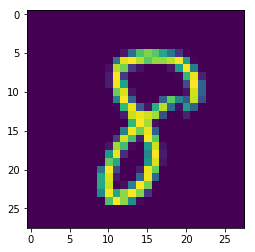

In [5]:
#Visualizing MNIST
X = X_train.reshape(48000, 28, 28)
i = np.random.choice(range(len(X)))
plt.imshow(X[i], interpolation = 'nearest')
print("Number of this picture is", y_train[i])

In [6]:
count = 1

def MNIST_train(X, y, lambd = 0, epoch = 7, learning_rate = 0.01, test = False):
    global count
    np.random.seed(1)
    fc_W = dict()
    fc_b = dict()
    fc_gamma = dict()
    fc_beta = dict()
    fc_mean = dict()
    fc_std = dict()
    X_train = X
    y_train = y
    
    Convolution_layer = [(28 * 28, 9, 10), (28 * 28, 9 * 10, 4)]
    FC_layer = [28 * 28 * 4, 128, 10]
    order = [len(Convolution_layer), len(FC_layer) - 1]

    # Set Convolution Layer
    for i, v in enumerate(Convolution_layer):
        W, gamma, beta, mean, std = "CW" + str(i), "Cz" + str(i + 1),\
                                    "Cz" + str(i + 1), "Cz" + str(i + 1), "Cz" + str(i + 1)
        n_in, n_f_size, n_f_num = v
        fc_W[W] = dict()
        fc_W[W][0] = np.random.randn(n_f_size, n_f_num) / np.sqrt(n_f_size / 2)
        fc_W[W][1], fc_W[W][2] = np.zeros(fc_W[W][0].shape), np.zeros(fc_W[W][0].shape)
        fc_gamma[gamma] = dict()
        fc_gamma[gamma][0] = np.random.randn(n_in, n_f_num)
        fc_gamma[gamma][1], fc_gamma[gamma][2] = np.zeros(fc_gamma[gamma][0].shape), np.zeros(fc_gamma[gamma][0].shape)
        fc_beta[beta] = dict()
        fc_beta[beta][0] = np.random.randn(n_in, n_f_num)
        fc_beta[beta][1], fc_beta[beta][2] = np.zeros(fc_beta[beta][0].shape), np.zeros(fc_beta[beta][0].shape)
        fc_mean[mean] = np.zeros((n_in, n_f_num))
        fc_std[std] = np.zeros((n_in, n_f_num))

    # Set Fully Connected Area
    for i in range(len(FC_layer) - 1):
        W, b, gamma, beta, mean, std = "W" + str(i), "b" + str(i), "z" + str(i + 1),\
                                       "z" + str(i + 1), "z" + str(i + 1), "z" + str(i + 1)
        n_in, n_out = FC_layer[i], FC_layer[i + 1]
        fc_W[W] = dict()
        fc_W[W][0] = np.random.randn(n_in, n_out) / np.sqrt(n_in / 2)
        fc_W[W][1], fc_W[W][2] = np.zeros(fc_W[W][0].shape), np.zeros(fc_W[W][0].shape)
        fc_b[b] = dict()
        fc_b[b][0] = np.zeros(n_out)
        fc_b[b][1], fc_b[b][2] = np.zeros(fc_b[b][0].shape), np.zeros(fc_b[b][0].shape)
        fc_gamma[gamma] = dict()
        fc_gamma[gamma][0] = np.random.randn(n_out)
        fc_gamma[gamma][1], fc_gamma[gamma][2] = np.zeros(fc_gamma[gamma][0].shape), np.zeros(fc_gamma[gamma][0].shape)
        fc_beta[beta] = dict()
        fc_beta[beta][0] = np.random.randn(n_out)
        fc_beta[beta][1], fc_beta[beta][2] = np.zeros(fc_beta[beta][0].shape), np.zeros(fc_beta[beta][0].shape)
        fc_mean[mean] = np.zeros(n_out)
        fc_std[std] = np.zeros(n_out)
    training_cost = []
    # Training Start
    for epo in range(epoch):
        for i in range(0, X_train.shape[0], 128):
            X_mini = X_train[i:i + 128]
            y_mini = y_train[i:i + 128]
            if test == True:
                numerical_check(order, X_mini, y_mini, fc_W, fc_b, fc_gamma, fc_beta, fc_mean, fc_std, lambd)
            #forward
            cache = forward(order, X_mini, fc_W, fc_b, fc_gamma, fc_beta, fc_mean, fc_std)
            if (count - 1) % 100 == 0:
                training_cost.append(nn_cost(y_mini, cache['x'][-1], fc_W, lambd))
            #backward
            backward(order, cache, fc_W, fc_b, fc_gamma, fc_beta, fc_mean, fc_std, y_mini, learning_rate, test, lambd)
            if (count - 1) % 100 == 0:
                print(count - 1, "lambda =", lambd, ", iteration finished, Cost =", training_cost[-1])
            count += 1
            if count == 2:
                test = False

    parameters = [fc_W, fc_b, fc_gamma, fc_beta, fc_mean, fc_std]
    count = 1
    return training_cost, parameters, order

In [7]:
def forward(order, X_first, W, b, gamma, beta, mean, std):
    cache = dict()
    cache['x'] = [X_first]
    cache['x_col'] = []
    cache['z'] = []
    cache['z_bar'] = []
    cache['z_y'] = []
    cache['z_mean'] = []
    cache['z_std'] = []
    # Convolution
    for layer in range(order[0]):
        keyW, keyz = "CW" + str(layer), "Cz" + str(layer + 1)
        cache['x_col'].append(im2col(cache['x'][-1]))
        # After Convolution
        cache['z'].append(conv(cache['x_col'][-1], W[keyW][0]))
        # Batch
        z_bar, z_y, z_mean, z_std = nn_batch(cache['z'][-1], gamma[keyz][0], beta[keyz][0], mean[keyz], std[keyz])
        cache['z_bar'].append(z_bar)
        cache['z_y'].append(z_y)
        cache['z_mean'].append(z_mean)
        cache['z_std'].append(z_std)
        if layer != order[0] - 1:
            cache['x'].append(conv_leaky_relu(cache['z_y'][-1]))
        else:
            k = conv_leaky_relu(cache['z_y'][-1])
            cache['x'].append(k.reshape((k.shape[0], k.shape[1] * k.shape[2] * k.shape[3])))
    # Fully Connected Neural Network
    for layer in range(order[1]):
        keyW, keyb, keyz = "W" + str(layer), "b" + str(layer), "z" + str(layer + 1)
        cache['z'].append(nn_fc(cache['x'][-1], W[keyW][0], b[keyb][0]))
        #Batch
        z_bar, z_y, z_mean, z_std = nn_batch(cache['z'][-1], gamma[keyz][0], beta[keyz][0], mean[keyz], std[keyz])
        cache['z_bar'].append(z_bar)
        cache['z_y'].append(z_y)
        cache['z_mean'].append(z_mean)
        cache['z_std'].append(z_std)
        #softmax
        if layer == order[1] - 1:
            cache['x'].append(nn_softmax(cache['z_y'][-1]))
        else:
            cache['x'].append(nn_leaky_relu(cache['z_y'][-1]))
    return cache

In [8]:
def backward(order, cache, W, b, gamma, beta, mean, std, y, learning_rate, test, lambd):
    dy = cache['x'].pop()
    #dy /= dy.shape[0]
    compare = deque()
    for layer in range(order[1] - 1, -1, -1):
        keyW, keyb, keyz = "W" + str(layer), "b" + str(layer), "z" + str(layer + 1)
        if layer == order[1] - 1:
            cache['z_y'].pop()
            dy[np.arange(y.shape[0]), y] -= 1
            dy /= y.shape[0]
        else:
            dy[(cache['z_y'].pop()) < 0] *= 0.01
        # batch
        dy, dgamma, dbeta = nn_grad_batch(cache['z'].pop(), cache['z_bar'].pop(), dy, gamma[keyz][0], \
                                          cache['z_mean'].pop(), cache['z_std'].pop())
        if test == True:
            compare.append((keyz, "beta", dbeta[:3]))
            compare.append((keyz, "gamma", dgamma[:3]))
        update(beta[keyz][0], dbeta, beta[keyz][1], beta[keyz][2], learning_rate)
        update(gamma[keyz][0], dgamma, gamma[keyz][1], gamma[keyz][2], learning_rate)
        # FC
        dW, db, dy = nn_grad(cache['x'].pop(), W[keyW][0], b[keyb][0], dy, lambd)
        if test == True:
            compare.append((keyb, db[:3]))
            compare.append((keyW, dW[:3, :3]))
        update(b[keyb][0], db, b[keyb][1], b[keyb][2], learning_rate)
        update(W[keyW][0], dW, W[keyW][1], W[keyW][2], learning_rate)
    # Convolution
    dy = dy.reshape(dy.shape[0], 4, 28, 28)
    for layer in range(order[0] - 1, -1, -1):
        keyW, keyz = "CW" + str(layer), "Cz" + str(layer + 1)
        # Leaky relu
        dy = flatten(dy, (cache['z_y']).pop())
        # batch
        dy, dgamma, dbeta = nn_grad_batch(cache['z'].pop(), cache['z_bar'].pop(), dy, gamma[keyz][0], \
                                          cache['z_mean'].pop(), cache['z_std'].pop())
        if test == True:
            compare.append((keyz, "beta", dbeta[:3, :3]))
            compare.append((keyz, "gamma", dgamma[:3, :3]))
        update(beta[keyz][0], dbeta, beta[keyz][1], beta[keyz][2], learning_rate)
        update(gamma[keyz][0], dgamma, gamma[keyz][1], gamma[keyz][2], learning_rate)
        # Conv
        dW, dy = nn_conv_grad(cache['x_col'].pop(), W[keyW][0], dy, lambd)
        if test == True:
            compare.append((keyW, dW[:3, :3]))
        update(W[keyW][0], dW, W[keyW][1], W[keyW][2], learning_rate)
        dy = col2im(dy, cache['x'].pop())
    if test == True:
        print("Derivation")
        while len(compare) > 0:
            a = compare.pop()
            print(a[:-1])
            print(a[-1])
            print()

In [9]:
def im2col(X):
    temp = np.pad(X, ((0, 0), (0, 0), (1, 1), (1, 1)), 'constant', constant_values = ((0, 0), (0, 0), (0, 0), (0, 0)))
    X_col = np.zeros((X.shape[0], X.shape[2] * X.shape[3], 9 * X.shape[1]))
    for n in range(X.shape[0]):
        count = 0
        for i in range(X.shape[2]):
            for j in range(X.shape[3]):
                X_col[n, count] = temp[n, :, i:i + 3, j:j + 3].reshape(9 * X.shape[1])
                count += 1
    return X_col

In [10]:
def conv(X, W):
    # X = N, 28 * 28, 9 * 8, W = 9 * 8, 4
    # y = N, 28 * 28, 4
    y = np.matmul(X, W)#.transpose(0, 2, 1).reshape((X.shape[0], W.shape[1], 28, 28)
    return y

In [11]:
def nn_batch(z, z_gamma, z_beta, z_mean, z_std, epsilon = 0.000001):
    mean = z.mean(axis = 0)
    std = (z.var(axis = 0) + epsilon) ** (1 / 2)
    z_mean *= 0.99
    z_mean += 0.01 * mean
    z_std *= 0.99
    z_std += 0.01 * std
    z_x_bar = (z - mean) / std
    z_y = z_gamma * z_x_bar + z_beta
    return z_x_bar, z_y, mean, std

In [12]:
def conv_leaky_relu(X):
    y = X.transpose(0, 2, 1).reshape(X.shape[0], X.shape[2], 28, 28)
    y[y < 0] *= 0.01
    return y

In [13]:
def nn_fc(X, W, b):
    return np.matmul(X, W) + b

In [14]:
def nn_leaky_relu(X):
    y = X.copy()
    y[y < 0] *= 0.01
    return y

In [15]:
def nn_softmax(x):
    y = np.exp(x)
    y /= y.sum(axis = 1, keepdims = True)
    return y

In [16]:
def nn_cost(y, y_hat, W, lambd):
    cost = np.sum(-np.log(y_hat[np.arange(y_hat.shape[0]), y])) / y.shape[0]
    for key in W:
        cost += np.sum(W[key][0] ** 2) * (lambd / (2 * y.shape[0]))
    return cost

In [17]:
def nn_grad_batch(x, x_bar, dy, gamma, mean, std):
    m = x.shape[0]
    dx_bar = dy * gamma
    dx = (1 / (m * std)) * (m * dx_bar - np.sum(dx_bar, axis=0) - x_bar * np.sum(dx_bar * x_bar, axis=0))
    dgamma = np.sum(dy * x_bar, axis = 0)
    dbeta = np.sum(dy, axis = 0)
    return dx, dgamma, dbeta

In [18]:
def nn_grad(x, W, b, dy, lambd):
    dW = np.matmul(x.T, dy) + (lambd / x.shape[0]) * W
    db = np.sum(dy, axis = 0)
    dX = np.matmul(dy, W.T)
    return dW, db, dX

In [19]:
def flatten(dy, y):
    dy = dy.reshape(y.shape[0], y.shape[2], y.shape[1]).transpose(0, 2, 1)
    dy[y < 0] *= 0.01
    return dy

In [20]:
def col2im(X_col, X):
    X_im = np.zeros((X.shape[0], X.shape[1], X.shape[2] + 2, X.shape[3] + 2))
    for n in range(X_col.shape[0]):
        a, b = 0, 0
        for i in range(X_col.shape[1]):
            X_im[n, :, a:a + 3, b:b + 3] += X_col[n, i].reshape(X.shape[1], 3, 3)
            b += 1
            if b + 3 > X_im.shape[3]:
                a += 1
                b = 0
    return X_im[:, :, 1:-1, 1:-1]

In [21]:
def nn_conv_grad(x, W, dy, lambd):
    dW = np.sum(np.matmul(x.transpose(0, 2, 1), dy), axis = 0) + (lambd / x.shape[0]) * W
    dX = np.matmul(dy, W.T)
    return dW, dX

In [22]:
def update(W, dW, Wm, Wv, alpha, beta1 = 0.9, beta2 = 0.999, epsilon = (10 ** (-8))):
    global count
    alpha *= (1 / 2) ** (count / 100)
    Wm *= beta1
    Wm += (1 - beta1) * dW
    Wv *= beta2
    Wv += (1 - beta2) * (dW ** 2)
    W -= (alpha * Wm / (1 - (beta1 ** count))) / np.sqrt((Wv / (1 - (beta2 ** count))) + epsilon)

In [23]:
def numerical_check(order, X_first, y, W, b, gamma, beta, mean, std, lambd, h = 0.00001):
    print("Numerical")
    #Convolution
    for layer in range(order[0]):
        keyW, keyz = "CW" + str(layer), "Cz" + str(layer + 1)
        W_test = np.zeros((3, 3))
        gamma_test = np.zeros((3, 3))
        beta_test = np.zeros((3, 3))
        for i in range(3):
            for j in range(3):
                W[keyW][0][i][j] += h
                cost1 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
                W[keyW][0][i][j] -= 2 * h
                cost2 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
                W_test[i][j] = (cost1 - cost2) / (2 * h)
                W[keyW][0][i][j] += h
        for i in range(3):
            for j in range(3):
                gamma[keyz][0][i][j] += h
                cost1 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
                gamma[keyz][0][i][j] -= 2 * h
                cost2 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
                gamma_test[i][j] = (cost1 - cost2) / (2 * h)
                gamma[keyz][0][i][j] += h
        for i in range(3):
            for j in range(3):
                beta[keyz][0][i][j] += h
                cost1 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
                beta[keyz][0][i][j] -= 2 * h
                cost2 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
                beta_test[i][j] = (cost1 - cost2) / (2 * h)
                beta[keyz][0][i][j] += h
        print((keyW))
        print(W_test)
        print()
        print((keyz, "gamma"))
        print(gamma_test)
        print()
        print((keyz, "beta"))
        print(beta_test)
    #Batch
    for layer in range(order[1]):
        keyW, keyb, keyz = "W" + str(layer), "b" + str(layer), "z" + str(layer + 1)
        W_test = np.zeros((3, 3))
        b_test = np.zeros(3)
        gamma_test = np.zeros(3)
        beta_test = np.zeros(3)
        for i in range(3):
            for j in range(3):
                W[keyW][0][i][j] += h
                cost1 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
                W[keyW][0][i][j] -= 2 * h
                cost2 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
                W_test[i][j] = (cost1 - cost2) / (2 * h)
                W[keyW][0][i][j] += h
        for i in range(3):
            b[keyb][0][i] += h
            cost1 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
            b[keyb][0][i] -= 2 * h
            cost2 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
            b_test[i] = (cost1 - cost2) / (2 * h)
            b[keyb][0][i] += h
        for i in range(3):
            gamma[keyz][0][i] += h
            cost1 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
            gamma[keyz][0][i] -= 2 * h
            cost2 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
            gamma_test[i] = (cost1 - cost2) / (2 * h)
            gamma[keyz][0][i] += h
        for i in range(3):
            beta[keyz][0][i] += h
            cost1 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
            beta[keyz][0][i] -= 2 * h
            cost2 = numerical_forward(order, X_first, y, W, b, gamma, beta, lambd)
            beta_test[i] = (cost1 - cost2) / (2 * h)
            beta[keyz][0][i] += h
        print((keyW))
        print(W_test)
        print()
        print((keyb))
        print(b_test)
        print()
        print((keyz, "gamma"))
        print(gamma_test)
        print()
        print((keyz, "beta"))
        print(beta_test)

In [24]:
def numerical_forward(order, X_first, y, W, b, gamma, beta, lambd):
    #Convolution
    y_hat = X_first
    for layer in range(order[0]):
        keyW, keyz = "CW" + str(layer), "Cz" + str(layer + 1)
        y_hat = im2col(y_hat)
        # After Convolution
        y_hat = conv(y_hat, W[keyW][0])
        # Batch
        y_hat = numerical_batch(y_hat, gamma[keyz][0], beta[keyz][0])
        if layer != order[0] - 1:
            y_hat = conv_leaky_relu(y_hat)
        else:
            k = conv_leaky_relu(y_hat)
            y_hat = k.reshape(k.shape[0], k.shape[1] * k.shape[2] * k.shape[3])
    #Batch
    for layer in range(order[1]):
        keyW, keyb, keyz = "W" + str(layer), "b" + str(layer), "z" + str(layer + 1)
        y_hat = nn_fc(y_hat, W[keyW][0], b[keyb][0])
        #Batch
        y_hat = numerical_batch(y_hat, gamma[keyz][0], beta[keyz][0])
        #softmax
        if layer == order[1] - 1:
            y_hat = nn_softmax(y_hat)
        else:
            y_hat = nn_leaky_relu(y_hat)
    cost = nn_cost(y, y_hat, W, lambd)
    return cost

In [25]:
def numerical_batch(z, z_gamma, z_beta, epsilon = 0.000001):
    mean = z.mean(axis = 0)
    std = (z.var(axis = 0) + epsilon) ** (1 / 2)
    z_x_bar = (z - mean) / std
    z_y = z_gamma * z_x_bar + z_beta
    return z_y

In [26]:
def predict(X, y, parameters, order):
    y_hat = test_forward(X, y, parameters, order)
    y_hat = np.argmax(y_hat, axis = 1)
    return y_hat

In [27]:
def accuracy(X, y, parameters, order):
    y_hat = test_forward(X, y, parameters, order)
    y_hat = np.argmax(y_hat, axis = 1)
    return np.sum(y == y_hat)

In [28]:
def test_forward(X, y, parameters, order):
    y_hat = X
    W, b, gamma, beta, mean, std = parameters
    for layer in range(order[0]):
        keyW, keyz = "CW" + str(layer), "Cz" + str(layer + 1)
        y_hat = im2col(y_hat)
        y_hat = conv(y_hat, W[keyW][0])
        y_hat = test_batch(y_hat, mean[keyz], std[keyz], gamma[keyz][0], beta[keyz][0])
        if layer != order[0] - 1:
            y_hat = conv_leaky_relu(y_hat)
        else:
            k = conv_leaky_relu(y_hat)
            y_hat = k.reshape(k.shape[0], k.shape[1] * k.shape[2] * k.shape[3])

    for layer in range(order[1]):
        keyW, keyb, keyz = "W" + str(layer), "b" + str(layer), "z" + str(layer + 1)
        y_hat = nn_fc(y_hat, W[keyW][0], b[keyb][0])
        #Batch
        y_hat = test_batch(y_hat, mean[keyz], std[keyz], gamma[keyz][0], beta[keyz][0])
        #softmax
        if layer != order[1] - 1:
            y_hat = nn_leaky_relu(y_hat)
    return y_hat

In [29]:
def test_batch(z, mean, std, z_gamma, z_beta):
    z_x_bar = (z - mean) / std
    z_y = z_gamma * z_x_bar + z_beta
    return z_y

In [30]:
L2regul = [0]

accuracy_train = []
accuracy_cross = []
lambd_cost = []
lambd_parameters = []

for lamb in L2regul:
    cost, parameters, order = MNIST_train(X_train, y_train, lambd = lamb)
    lambd_parameters.append(parameters)
    lambd_cost.append(cost)
    acc = 0
    for i in range(0, X_train.shape[0], 128):
        acc += accuracy(X_train[i:i + 128], y_train[i:i + 128], parameters, order)
    accuracy_train.append(acc / X_train.shape[0] * 100)
    acc = 0
    for i in range(0, X_cross.shape[0], 128):
        acc += accuracy(X_cross[i:i + 128], y_cross[i:i + 128], parameters, order)
    accuracy_cross.append(acc / X_cross.shape[0] * 100)

0 lambda = 0 , iteration finished, Cost = 3.07143362129
100 lambda = 0 , iteration finished, Cost = 0.440736557684
200 lambda = 0 , iteration finished, Cost = 0.310685860235
300 lambda = 0 , iteration finished, Cost = 0.188330600177
400 lambda = 0 , iteration finished, Cost = 0.215203676572
500 lambda = 0 , iteration finished, Cost = 0.151857726934
600 lambda = 0 , iteration finished, Cost = 0.202990221467
700 lambda = 0 , iteration finished, Cost = 0.171946274107
800 lambda = 0 , iteration finished, Cost = 0.241236623658
900 lambda = 0 , iteration finished, Cost = 0.169669222248
1000 lambda = 0 , iteration finished, Cost = 0.17798442258
1100 lambda = 0 , iteration finished, Cost = 0.17059395453
1200 lambda = 0 , iteration finished, Cost = 0.153190464082
1300 lambda = 0 , iteration finished, Cost = 0.135935448401
1400 lambda = 0 , iteration finished, Cost = 0.185079251189
1500 lambda = 0 , iteration finished, Cost = 0.179048854119
1600 lambda = 0 , iteration finished, Cost = 0.14380225

[96.0625] [95.183333333333337]


([<matplotlib.axis.XTick at 0x1d2a1f07d68>],
 <a list of 1 Text xticklabel objects>)

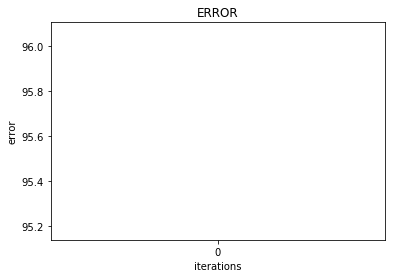

In [31]:
print(accuracy_train, accuracy_cross)

plt.plot(range(len(L2regul[:2])), accuracy_train)
plt.plot(range(len(L2regul[:2])), accuracy_cross)
plt.xlabel("iterations")
plt.ylabel("error")
plt.title("ERROR")
plt.xticks(range(len(L2regul[:2])), L2regul)

In [32]:
acc = 0
for i in range(0, X_test.shape[0], 512):
    acc += accuracy(X_test[i:i + 512], y_test[i:i + 512], lambd_parameters[0], order)
acc /= X_test.shape[0]

print("Test accuracy is", acc * 100, "%")

Test accuracy is 95.62 %


real class is 7
predict = 7


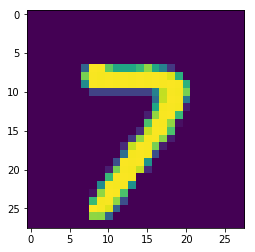

In [34]:
i = np.random.choice(range(len(X_test)))
plt.imshow(X_test[i].reshape((28, 28)), interpolation='nearest')
print("real class is", y_test[i])
print("predict =", predict(X_test[i:i + 1], y_test[i:i + 1], lambd_parameters[0], order)[0])

In [ ]:
plt.plot(range(len(lambd_cost[0])), lambd_cost[0])